In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#Window Datasetnya
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

# Untuk Plot Series
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Date")
    plt.ylabel("Price")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


# Load Dataset

In [ ]:
# Nama file dataset
ds_komoditas = "Cabai Merah Keriting"

df = pd.read_csv(f'{ds_komoditas}.csv')
df['Date']=pd.to_datetime(df['Date'], format='%Y-%m-%d')
# set the Date column be the index of our dataset
df.set_index('Date', inplace=True)

prices = df['Price'].values
time_step = df.index.values

# Normalisasi Dataset

In [ ]:
# Normalisasi
min=np.min(prices)
max=np.max(prices)
prices -= min
prices /= max

## Train Validation Split

In [ ]:
split_time = int(len(prices) * 0.8)

x_train = prices[:split_time]
x_valid = prices[split_time:]

In [ ]:
window_size=64
batch_size=256
shuffle_buffer_size=1000

train_set=windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
validation_set=windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

# Mendefinisikan Model

In [ ]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv1D(filters=32, kernel_size=5,
#                            strides=1, padding="causal",
#                            activation="relu",
#                            input_shape=[None, 1]),
#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(30, activation="relu"),
#     tf.keras.layers.Dense(10, activation="relu"),
#     tf.keras.layers.Dense(1)
# ])

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),

    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

In [ ]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Callback untuk mencegah overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=10,
    restore_best_weights=True
)

#Training Model
model.fit(train_set, epochs=100, validation_data=validation_set, callbacks=[early_stopping])

Epoch 1/100
3/3 [==============================] - 21s 1s/step - loss: 59.0623 - mae: 6.1221 - val_loss: 4.4497 - val_mae: 2.0228
Epoch 2/100
3/3 [==============================] - 1s 352ms/step - loss: 9.3563 - mae: 2.7479 - val_loss: 1.9921 - val_mae: 1.3628
Epoch 3/100
3/3 [==============================] - 2s 544ms/step - loss: 2.8181 - mae: 1.5752 - val_loss: 1.0063 - val_mae: 0.9405
Epoch 4/100
3/3 [==============================] - 2s 449ms/step - loss: 1.3033 - mae: 1.0055 - val_loss: 2.8283 - val_mae: 1.4910
Epoch 5/100
3/3 [==============================] - 1s 357ms/step - loss: 1.5600 - mae: 0.9998 - val_loss: 1.2433 - val_mae: 1.1050
Epoch 6/100
3/3 [==============================] - 1s 345ms/step - loss: 0.9873 - mae: 0.8581 - val_loss: 0.0695 - val_mae: 0.2275
Epoch 7/100
3/3 [==============================] - 1s 295ms/step - loss: 0.6085 - mae: 0.6432 - val_loss: 0.4273 - val_mae: 0.6056
Epoch 8/100
3/3 [==============================] - 1s 320ms/step - loss: 0.5848 - ma

# Kita Tes Yagesya

In [ ]:
forecast = []
for time in range(len(prices) - window_size):
    forecast.append(model.predict(prices[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

1/1 [==============================] - 0s 26ms/step


# Visualisasi Hasil Prediksi Pada Validation Set

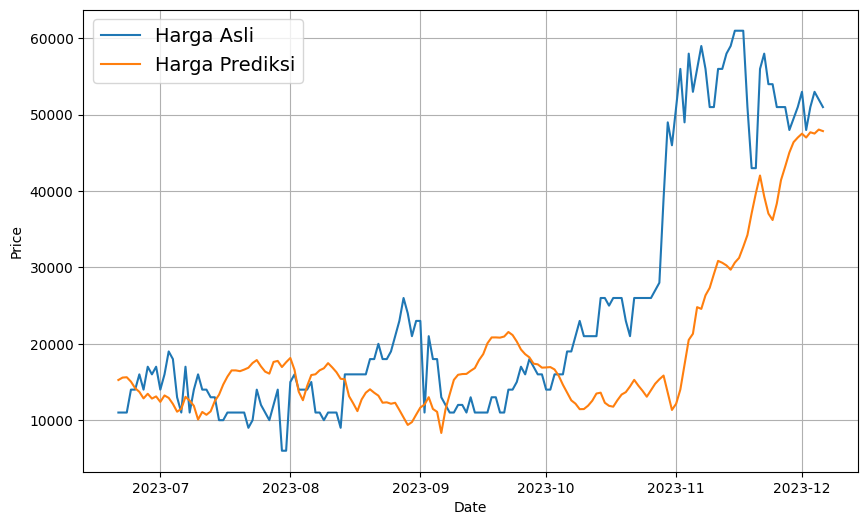

In [ ]:
plt.figure(figsize=(10, 6))

plot_series(time_step[split_time:], x_valid * max, label='Harga Asli')
plot_series(time_step[split_time:], results * max, label='Harga Prediksi')

plt.show()

In [ ]:
model.save('cabai_merah-v1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!pip install onnx==1.13.1
from tf2onnx import convert
from tf2onnx import convert

output_file = "cabai_merah-v1.onnx"
onnx_model, _ = convert.from_keras(model)

with open(output_file, "wb") as f:
    f.write(onnx_model.SerializeToString())

print(f"Model berhasil dikonversi ke {output_file}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 22.1 MB/s eta 0:00:00
  Attempting uninstall: onnx
    Found existing installation: onnx 1.14.1
    Uninstalling onnx-1.14.1:
      Successfully uninstalled onnx-1.14.1


ERROR:tf2onnx.tf_utils:pass1 convert failed for name: "sequential/conv1d/Conv1D"
op: "Conv2D"
input: "sequential/conv1d/Conv1D/ExpandDims"
input: "sequential/conv1d/Conv1D/ExpandDims_1"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "data_format"
  value {
    s: "NHWC"
  }
}
attr {
  key: "dilations"
  value {
    list {
      i: 1
      i: 1
      i: 1
      i: 1
    }
  }
}
attr {
  key: "explicit_paddings"
  value {
    list {
    }
  }
}
attr {
  key: "padding"
  value {
    s: "VALID"
  }
}
attr {
  key: "strides"
  value {
    list {
      i: 1
      i: 1
      i: 1
      i: 1
    }
  }
}
attr {
  key: "use_cudnn_on_gpu"
  value {
    b: true
  }
}
, ex=Could not infer attribute `explicit_paddings` type from empty iterator


ValueError: ignored

# Model v2

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(8, input_shape=[None, 1], activation='relu'),
    tf.keras.layers.GRU(16, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

In [ ]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Callback untuk mencegah overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=10,
    restore_best_weights=True
)

#Training Model
model.fit(train_set, epochs=100, validation_data=validation_set, callbacks=[early_stopping])

In [ ]:
forecast = []
for time in range(len(prices) - window_size):
    forecast.append(model.predict(prices[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

In [ ]:
plt.figure(figsize=(10, 6))

plot_series(time_step[split_time:], x_valid * max, label='Harga Asli')
plot_series(time_step[split_time:], results * max, label='Harga Prediksi')

plt.show()